<a href="https://colab.research.google.com/github/mwithgod3952/jh_Natural_language_processing/blob/main/%EA%B0%9C%EC%B2%B4%EB%AA%85_%EC%9D%B8%EC%8B%9D_W%2C_Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 개체명 인식 개요

쳇봇의 종류 
  - 책봇은 크게 두가지 형태로 구분지을 수 있다. 
        Closed_Domain_Chatbot / Open_Domain_Chatbot
              Closed_Domain_Chatbot : 키워드와 인텐트를 기반으로 특정 업무 수행
              Open_Domain_Chatbot : Topic에 영향을 받지 않고 학습에 의해 점차 강화되어진 정보로 특정 업무를 수행.

  - 본 학습의 주요 목적은, 특정 산업에서의 정보탐색을 목적으로 하기에, Closed_Domain_Chatbot에 중점을 두기로 하고 Closed_Domain_Chatbot에 대해 정리해본다.

        Closed_Domain_Chatbot은 두개의 Model 제작을 필요로 한다. 
        위에서 언급한, 키워드와 인텐트와 관련한 모델이다.
              사람이 한 말 혹은 적은 문장/단락/글을 이해하기 위해,
              * 키워드 : 말하는 사람의 의도와 의도 안에 사용된 주요 키워드를 파학해 내는 것 (통상, Named entity recognition)

              * 인텐트 : 키워드를 기반으로 자연어로 이야기 했을 때, 의도를 파악하는 것 (통상, Intent Classification)
              () : 키워드
                  Ex) (소리)가 너무 (작아) : 소리좀 키워줘
                  Ex) 내 (보험)(조회) : 내 보험조회(확인)        
                  Ex) (보험)(계약)(대출) : (보험)(계약)(대출) 문의하고 싶어요.


In [ ]:
# import tensorflow as tf
# tf.__version__

In [ ]:
# !pip uninstall tensorflow

In [ ]:
# !pip install tensorflow==1.14.0
# !pip install keras==2.2.4
# !pip install tensorflow-gpu==1.14.0

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk import word_tokenize, pos_tag, ne_chunk

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


- 앞서 품사 태깅(pos_tag)을 수행 
- ne_chunk를 통해 개채명 인식 

In [ ]:
sentence = "James is working at Disney in London"
sentence=pos_tag(word_tokenize(sentence))
sentence

[('James', 'NNP'),
 ('is', 'VBZ'),
 ('working', 'VBG'),
 ('at', 'IN'),
 ('Disney', 'NNP'),
 ('in', 'IN'),
 ('London', 'NNP')]

In [ ]:
sentence=ne_chunk(sentence)
print(sentence) # 개체명 인식

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


---

## 양방향 LSTM을 이용한 개체명 인식

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_name='/content/drive/MyDrive/ner_data/ner_dataset.csv' 
data = pd.read_csv(file_name, encoding="latin1")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  47959 non-null    object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [ ]:
data[:5]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [ ]:
print('Sentence # 열에 대해 중복을 제거한 값의 개수 : {}'.format(data['Sentence #'].nunique()))
print('Word 열에 대해 중복을 제거한 값의 개수 : {}'.format(data['Word'].nunique()))
print('POS 열에 대해 중복을 제거한 값의 개수 : {}'.format(data['POS'].nunique()))
print('Tag 열에 대해 중복을 제거한 값의 개수 : {}'.format(data['Tag'].nunique()))

Sentence # 열에 대해 중복을 제거한 값의 개수 : 47959
Word 열에 대해 중복을 제거한 값의 개수 : 35178
POS 열에 대해 중복을 제거한 값의 개수 : 42
Tag 열에 대해 중복을 제거한 값의 개수 : 17


즉, 위 데이터 셋을 분석한 결과는 다음과 같다.

     - 전체 문장 47959개 는, 35178개의 단어를 가지공 있으며, 17개의 Tag를 통해 구분됨

---

In [ ]:
data.groupby('Tag').size().reset_index(name='count')

,Tag,count
0,B-art,402
1,B-eve,308
2,B-geo,37644
3,B-gpe,15870
4,B-nat,201
5,B-org,20143
6,B-per,16990
7,B-tim,20333
8,I-art,297
9,I-eve,253


***전체의 데이터셋에서, 17 개의 개체명 태그의 분포를 확인***  

    BIO Tagging
          - B는 Begin의 약자로 개체명이 시작되는 부분
          - I는 Inside의 약자로 개체명의 내부 부분
          - O는 Outside의 약자로 개체명이 아닌 부분을 의미

Ex_1)

해-B(movie)
리-I(movie)
포-I(movie)
터-I(movie)
보-O
러-O
가-O
자-O
메-B(theater)
가-I(theater)
박-I(theater)
스-I(theater)
에-O
서-O
보-O
자-O 

Ex_2)

해리포터-B(move)
와-I(move) 
마법사-I(move)
의-I(move)
돌-I(move)
을-O
저녁-B(time)
7시-I(time)
에-O 
예매-O
해줘-O


In [ ]:
# null 값 제거 
# 우리는 상단에서, Null값이 한 문장 안에 종속되는 단어들임을 구분하기 위해, 자연수럽게 생긴 null의 공간임을 파악하였다.
# 이런 이유로, 나는 행을 제거하는 것이 아니라, 최 상위의 Sentence라는 str 값을 카피하여 값을 대체시키고자 한다.

data = data.fillna(method='ffill')
data.tail()

,Sentence #,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [ ]:
data.isnull().values.any()

False

In [ ]:
data['Word'] = data['Word'].str.lower() 

In [ ]:
data['Word'].tail()

1048570         they
1048571    responded
1048572           to
1048573          the
1048574       attack
Name: Word, dtype: object

In [ ]:
func = lambda temp: [(w,t) for w, t in zip(temp['Word'].values.tolist(), temp['Tag'].values.tolist())]
tagged_sentences = [t for t in data.groupby('Sentence #').apply(func)]

In [ ]:
len(tagged_sentences)

47959

In [ ]:
tagged_sentences[0]

[('thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('london', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('british', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [ ]:
sentences, ner_tags = [], []
for X in tagged_sentences:
  sentence, tag_info = zip(*X)
  sentences.append(list(sentence))
  ner_tags.append(list(tag_info))  

In [ ]:
print(sentences[98])
print(ner_tags[98])

['she', 'had', 'once', 'received', 'a', 'kidney', 'transplant', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 104
샘플의 평균 길이 : 21.863988


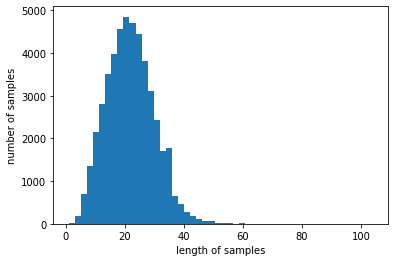

In [ ]:
print('샘플의 최대 길이 %d' % max([len(le) for le in sentences]))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 정수 인코딩

In [ ]:
src_tokenizer = Tokenizer(oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False)
tar_tokenizer.fit_on_texts(ner_tags)

In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 31819
개체명 태깅 정보 집합의 크기 : 18


In [ ]:
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


* 정수 인코딩에 대한 상단의 내용 정리

      - 위의 과정은 정수 인코딩을 위한 모델생성 과정이다.
      - 위 과정에서 유의하여 확인할 것은, 
                  1. 'OOV' 에 대한 인덱스(1)를 모델 생성 과정에서 지정해주었다는 것.
                  2. Tag 정보를 확인했을 때, 대문자가 혼용된 형태라는 것을 확인했기 때문에, 이에 대한 부분 역시 대문자를 유지하겠다는 명령을 모델 생성과정에서 지정해주었다는 점


In [ ]:
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
print(X_data[0][:10])
print(y_data[0][:10])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1]


***LSTM에 적제하기 위해 texts_to_sequences를 통해 '문장'과 '테그'를 토큰화 시켰으며 통기에 모델에 적제하기 위해 입력과, 타겟으로 각 시퀀스를 저장하였다.***

In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [ ]:
print(ner_to_index)
# 아 O가 1로 encoding된 것 을 모델 상에서 가장 빈도수가 높은 Tag가 1로 할당되엇다는 것을 확인할 수 있었음

{'O': 1, 'B-geo': 2, 'B-tim': 3, 'B-org': 4, 'I-per': 5, 'B-per': 6, 'I-org': 7, 'B-gpe': 8, 'I-geo': 9, 'I-tim': 10, 'B-art': 11, 'B-eve': 12, 'I-art': 13, 'I-eve': 14, 'B-nat': 15, 'I-gpe': 16, 'I-nat': 17}


In [ ]:
print(index_to_ner)

{1: 'O', 2: 'B-geo', 3: 'B-tim', 4: 'B-org', 5: 'I-per', 6: 'B-per', 7: 'I-org', 8: 'B-gpe', 9: 'I-geo', 10: 'I-tim', 11: 'B-art', 12: 'B-eve', 13: 'I-art', 14: 'I-eve', 15: 'B-nat', 16: 'I-gpe', 17: 'I-nat', 0: 'PAD'}


***모델 훈련 후 결과 확인을 위해 인덱스로부터 단어를 리턴하는 index_to_word를 src_tokenizer 및 tar_tokenizer부터 도출***

In [ ]:
decoded = []
for index in X_data[0] :
    decoded.append(index_to_word[index]) 

print('기존의 문장 : {}'.format(sentences[0]))
print('디코딩 문장 : {}'.format(decoded))

기존의 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']
디코딩 문장 : ['thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'london', 'to', 'protest', 'the', 'war', 'in', 'iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'british', 'troops', 'from', 'that', 'country', '.']


***디코딩 테스트***

---

In [ ]:
max_len = 70

X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

***패딩***

      - 위에서 샘플들의 크기 분포를 Histogram 으로 확인했을 때, 
      최대값은 비록 104이지만, 대부분의 값 분포가 70임을 확인.
      - max_len을 70으로 지정하며, post단에 zero padding 진행. 

---

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [ ]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

***Y 정보에 대하여 One-Hot-Encoding을 진행***

In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


---

### F1 Score

In [ ]:
true=['B-PER', 'I-PER', 'O', 'O', 'B-MISC', 'O','O','O','O','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O','O','B-MISC','I-MISC','I-MISC','O','O','O','O','O','O','B-PER','I-PER','O','O','O','O','O']
# 실제값
predicted=['O'] * len(true) 
print(predicted)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
hit = 0
for t, p in zip(true, predicted):
  if t == p:
    hit +=1
accuracy = hit/len(true)
accuracy

0.7435897435897436

***위 결과를 통해 확인할 수 있는 것은 무엇인가! 비록 모델이 정답을 하나도 예측하지 못했으나, 실제 값에서 대부분의 분포가 'O' 즉 Outside 값인 관게로 모델의 정확도가 73%까지 올랐다는 것을 확인할 수 있다.***

---

위와 같은 이유로 우리는 f1-score 확인 이 필수적으로 필요하다.

***F1-Score에 대한 정의***


In [ ]:
from google.colab import files
uploaded = files.upload() 

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving Confussion_mt.png to Confussion_mt.png
User uploaded file "Confussion_mt.png" with length 91715 bytes


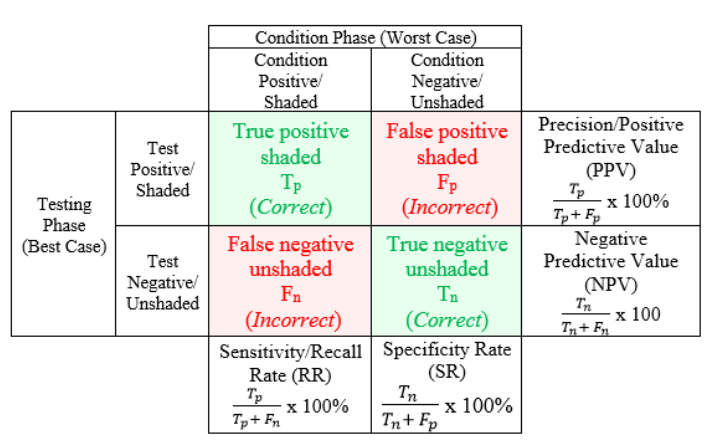

In [ ]:
from IPython.display import Image
Image('Confussion_mt.png')

Confussion Matrix 요소 :

    - Tp, Tn : 모델이 예측한 값이 정답인 비율
    - Fp : 모델이, 정답을 예측하지 못한 비율.   
    - Fn : 모델이, 정답이 아님을 예측하지 못한 비율.

  위와 같은 요소를 중심으로,

    - 정밀도(Positive predictive value) = 정답이 주어진 경우 정답을 예측한 비율
    - 재현률(recall) = 모델이 정답이라고 예측한 값들 중 실제로 정답이 차지하는 비율. 

위 두 요소 함께 재현하기 위한 Score가 f1 스코어이다.

    - 정밀도와 재현률의 합을 분모로, 곱을 분자로 한 비율에 Constant인 1을 Multiplying해준 값을 의미한다.

---

In [1]:
# !pip install seqeval

In [ ]:
from seqeval.metrics import classification_report
print(classification_report([true], [predicted]))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         2
         PER       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00         5
   macro avg       0.00      0.00      0.00         5
weighted avg       0.00      0.00      0.00         5



/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---

In [ ]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

Using TensorFlow backend.


---

In [ ]:
class Member:
    def __init__(self, name, age, address):
        self.name = name
        self.age = age
        self.address = address

    def info(self):
      print('저의 이름은 {0}이고, 나이는 {1}, 사는곳은 {2} 입니다'.format(self.name, self.age, self.address))

introduce = Member('jh', 30, '서울특별시')
introduce.info()

저의 이름은 jh이고, 나이는 30, 사는곳은 서울특별시 입니다


In [ ]:
class Parent:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
        
class Child(Parent):
    def __init__(self, c1, **kwargs):
        super(Child, self).__init__(**kwargs)
        self.c1 = c1
        self.c2 = "This is Child's c2"
        self.c3 = "This is Child's c3"

child = Child(p1="This is Parent's p1", 
              p2="This is Parent's p1", 
              c1="This is Child's c1")

print(child.p1)
print(child.p2)
print(child.c1)
print(child.c2)
print(child.c3)

This is Parent's p1
This is Parent's p1
This is Child's c1
This is Child's c2
This is Child's c3


***위는 간단히 Class와 속성, 메소드 간의 관계에 대해 코딩한 것이다***

        아래는, class 를 활용하여 f1 스코어 호추에 대한 class를 만들고자 한다.

---

In [ ]:
# from keras.callbacks import Callback
# 위에서 keras model에 적제되어 있는 Callback 이라는 부모 클래스를 F1score 를 자식 클레스로 하여금 사용하고자 한다.

class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): 
      result = []
      for sequence in sequences: 
          tag = []
          for pred in sequence: 
              pred_index = np.argmax(pred) 
              tag.append(index_to_ner[pred_index].replace("PAD", "O"))
          result.append(tag)
      return result

    def on_epoch_end(self, epoch, logs={}):

      if self.use_char:
        X_test = self.validation_data[0]
        X_char_test = self.validation_data[1]
        y_test = self.validation_data[2]
        y_predicted = self.model.predict([X_test, X_char_test])

      else:
        X_test = self.validation_data[0]
        y_test = self.validation_data[1]
        y_predicted = self.model.predict([X_test])

      pred_tags = self.sequences_to_tags(y_predicted)
      test_tags = self.sequences_to_tags(y_test)

      score = f1_score(pred_tags, test_tags)
      print(' - f1: {:04.2f}'.format(score * 100))
      print(classification_report(test_tags, pred_tags))

      if score > self.value:
        print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
        self.model.save('best_model.h5')
        self.value = score
      else:
        print('f1_score did not improve from %f'%(self.value))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam
from keras.models import load_model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10,  validation_split=0.1, callbacks=[F1score(use_char=False)])

Train on 34530 samples, validate on 3837 samples
Epoch 1/10
34530/34530 [==============================] - 406s 12ms/step - loss: 0.3092 - acc: 0.9218 - val_loss: 0.1518 - val_acc: 0.9540
 - f1: 73.23


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        37
         eve       0.00      0.00      0.00        30
         geo       0.72      0.84      0.77      3087
         gpe       0.92      0.94      0.93      1146
         nat       0.00      0.00      0.00        16
         org       0.55      0.51      0.53      1691
         per       0.60      0.67      0.63      1310
         tim       0.80      0.83      0.81      1672

   micro avg       0.71      0.75      0.73      8989
   macro avg       0.45      0.47      0.46      8989
weighted avg       0.70      0.75      0.73      8989

f1_score improved from 0.000000 to 0.732295, saving model to best_model.h5
Epoch 2/10
34530/34530 [==============================] - 405s 12ms/step - loss: 0.1199 - acc: 0.9636 - val_loss: 0.1383 - val_acc: 0.9577
 - f1: 66.93
              precision    recall  f1-score   support

         art       0.00      0.00      0.00        37
         eve 

In [ ]:
bilstm_model = load_model('best_model.h5')

In [ ]:
i=13 
y_predicted = bilstm_model.predict(np.array([X_test[i]])) 
y_predicted = np.argmax(y_predicted, axis=-1) 
true = np.argmax(y_test[i], -1) 
print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: 
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
the              : O       O
statement        : O       O
came             : O       O
as               : O       O
u.n.             : B-org   B-org
secretary-general: I-org   I-org
kofi             : B-per   B-per
annan            : I-per   I-per
met              : O       O
with             : O       O
officials        : O       O
in               : O       O
amman            : B-geo   B-geo
to               : O       O
discuss          : O       O
wednesday        : B-tim   B-tim
's               : O       O
attacks          : O       O
.                : O       O
